## Week - 8 - Deep Neural Nets and Text

In this week we introduce the use of Deep Neural Networks to work with text. We have already seen some uses of neural networks for text in our classification HW, where we used a simple neural network--the one-layer perceptron--to classify text. It performed quite well, but comes up short in more sophisticated classification tasks, such as in predicting intent. We have also seen slightly deeper, 2-level neural nets in the form of word embeddings such as Word2Vec. While they work well, they have some drawbacks, such as representing words with multiple meanings in a singular space. 

BERT, which is a language model built using bidirectional encoders, allows us to take advantage of a powerful pre-trained model which we can then use to perform our own tasks based on data we analyze. 

In this notebook we use ```huggingface/transformers```, a python package that allows for easy interface to use pre-trained BERT models. It is built using Tensorflow and PyTorch, two computational graph packages which are built specifically for creating powerful neural networks. We will also be introducing Keras, which allows us to easily build Neural Networks in an abstracted way. Keras is a popular way to understand how we can stack layers to create such Neural Networks, but to reach state-of-the-art results we will stick with using BERT and similar models that can be tuned to extremely high performance on specific language understanding and generation tasks.

To demonstrate this, we begin by using the [Corpus of Linguistic Acceptability](https://nyu-mll.github.io/CoLA/). We will also use BERT by learning how to extract embeddings from such a model and use it to semantically probe sentences. There are a number of new packages and methods we will be using so be sure to update lucem_illud_2020.

## NOTE

This notebook **requires** GPUs for training models in section 1 and section 3. To train models, please use this [Google Colab file](https://colab.research.google.com/drive/1_G6iGqiXb-zPBTurRxd7cgGrXyNaKGsA) to create the models. Note that I have only given you view access: please create your own colab file to train your models, using the code and instructions I have given in the Colab file. So while you have to do the homework on this notebook, the models which you will train should be done on Google Colab, which has GPU access. If you happen to have GPU access on your personal machines or some other way to train the models, you are welcome to do that too.

Note that if you run the computationally intensive models on your local computer they will take a long time!

In [4]:
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [5]:
%matplotlib inline

In [8]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

## CoLA Dataset and pre-processing

We start with loading our dataset and pre-processing it. The pre-processing follows similar steps as we have done in the past, but we will be using pre-written modules offered by the transformers package. These are some of the things we have to take care of when using this particular BERT model.

    -special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
    -tokens that conforms with the fixed vocabulary used in BERT
    -token IDs from BERT’s tokenizer
    -mask IDs to indicate which elements in the sequence are tokens and which are padding elements
    -segment IDs used to distinguish different sentences
    -positional embeddings used to show token position within the sequence


We will be using parts of the code from [this notebook](https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=BJR6t_gCQe_x) which walks us through the process of using a pre-trained BERT model. The interface to use these models comes from the package [huggingface/transformers](https://github.com/huggingface/transformers). 

We start by setting up our GPU if we can - this may not work on your machine, so it has been commented out.

An aside: check out this tutorial too - https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [9]:
gpu = torch.cuda.is_available()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu:
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [11]:
device

device(type='cpu')

In [12]:
df = pd.read_csv("../data/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [13]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [15]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [16]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [17]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [18]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [19]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

### Introducing Deep Neural Nets

A popular, simplified package for introducing deep neural networks is [Keras](https://keras.io). It is a high level package in that we don't bother with every detail or hyper-parameter associated with the neural network (e.g., regularizers), and can stack on layers directly. For a rapid tutorial on neural networks for text such as the LSTM or the Recurrent Neural Network, Colah's blog is a great start. [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is an article on LSTMs, and if you'd like to  learn about RNN, Andrej Karpathy does a great job in [this blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), in addition to our reading from the newest online verion of Jurafsky & Martin's review of deep learning methods in their book on speech and language processing, chapters [6,7,9,10](https://web.stanford.edu/~jurafsky/slp3/), and the [*Deep Learning*](https://www.deeplearningbook.org/) book by Goodfellow, Bengio & Courville.

In the following cells we build a basic deep net that has an embedding layer and an LSTM to perform classification. This is to illustrate the process of using Keras, which is a very popular library for such work. It may not yield state of the art performance because it constrains the hyperparameters you can tune, but is nonetheless an useful tool and works well on some datasets.

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [21]:
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [22]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 32)           976704    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
241/241 [==============================] - 16s 61ms/step - loss: 0.6216 - accuracy: 0.7026
Epoch 2/10
241/241 [==============================] - 15s 61ms/step - loss: 0.6027 - accuracy: 0.7118
Epoch 3/10
241/241 [==============================] - 15s 63ms/step - loss: 0.6068 - accuracy: 0.7063
Epoch 4/10
241/241 [==============================] - 15s 63ms/step - loss: 0.6030 - accuracy: 0.7113
Epoch 5/10
241/241 [==============================] - 16s 66ms/step - loss: 0.6130 - accuracy: 0.6978
Epoch 6/10
241/241 [==============================] - 16s 66ms/step - loss: 0.6098 - accuracy: 0.7023
Epoch 7/10
241/241 [==============================] - 15s 62ms/step - loss: 0.6054 - accuracy: 0.7074
Epoch 8/10
241/241 [==============================] - 17s 70ms/step - loss: 0.6078 - accuracy: 0.7045
Epoch 9/10
241/241 [==============================] - 16s 66ms/step - loss: 0.6176 - accuracy: 0.6931
Epoch 10/10
241/241 [==============================] - 16s 68ms/step - loss: 0.616

We can see that the accuracy of this model isn't terrible, but it still hovers around 70%. Below there is code for a slightly modified neural network - how does this one perform? Note that in this model, I have added another LSTM layer. You are encouraged to explore the [Keras documentaion](https://keras.io/layers/about-keras-layers/) to explore what kind of layers you can add and how they change performances for different tasks. Different kinds of losses, optimizers, activations and layers can change the flavour of your net dramatically.

In [19]:
# model_lstm2 = Sequential()
# model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
# model_lstm2.add(LSTM(units))
# model_lstm2.add(LSTM(units))
# model_lstm2.add(Dense(1, activation='sigmoid'))
# model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history_lstm2 = model_lstm2.fit(input_data_train, labels, epochs=10, batch_size=batch_size)

### On with BERT!

So while Neural Networks can do a good job with some kind of classification tasks, they don't perform too well on intent classification. Let us see how a bidirectional transformer embedding like BERT might do. 

In [24]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [25]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Loading our Models

### Train Model
Now that our input data is properly formatted, it's time to fine tune the BERT model.
For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.
We'll load BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.

### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.
Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

Credit to Michel Kana's [tutorial](https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03) and the [tutorial](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=GuE5BqICAne2) by Chris McCormick and Nick Ryan who describe the workings of BERT and the way it is used by the ```transformers``` package. 

## WARNING: SHIFT TO A GPU ENABLED MACHINE (e.g., Google Colab)

Note that you only want to run the following code if you have a GPU. Otherwise, rerun the **same** cells we just ran on the Colab file to train your model, download it to your local, and load it by running
```model = BertForSequenceClassification.from_pretrained("my_model_directory", num_labels=2)```.


In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# model.cuda()

In [23]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [25]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [26]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [27]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Note that the following cell can take upto 12 hours or longer if run without a GPU. The [Colab file](https://colab.research.google.com/drive/1_G6iGqiXb-zPBTurRxd7cgGrXyNaKGsA) demonstrates how to fine-tune models.

In [29]:
# import random

# # This training code is based on the `run_glue.py` script here:
# # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# # Set the seed value all over the place to make this reproducible.
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# # Store the average loss after each epoch so we can plot them.
# loss_values = []

# # For each epoch...
# for epoch_i in range(0, epochs):
    
#     # ========================================
#     #               Training
#     # ========================================
    
#     # Perform one full pass over the training set.

#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     print('Training...')

#     # Measure how long the training epoch takes.
#     t0 = time.time()

#     # Reset the total loss for this epoch.
#     total_loss = 0

#     # Put the model into training mode. Don't be mislead--the call to 
#     # `train` just changes the *mode*, it doesn't *perform* the training.
#     # `dropout` and `batchnorm` layers behave differently during training
#     # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
#     model.train()

#     # For each batch of training data...
#     for step, batch in enumerate(train_dataloader):

#         # Progress update every 40 batches.
#         if step % 40 == 0 and not step == 0:
#             # Calculate elapsed time in minutes.
#             elapsed = format_time(time.time() - t0)
            
#             # Report progress.
#             print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

#         # Unpack this training batch from our dataloader. 
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using the 
#         # `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids 
#         #   [1]: attention masks
#         #   [2]: labels 
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

#         # Always clear any previously calculated gradients before performing a
#         # backward pass. PyTorch doesn't do this automatically because 
#         # accumulating the gradients is "convenient while training RNNs". 
#         # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
#         model.zero_grad()        

#         # Perform a forward pass (evaluate the model on this training batch).
#         # This will return the loss (rather than the model output) because we
#         # have provided the `labels`.
#         # The documentation for this `model` function is here: 
#         # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#         outputs = model(b_input_ids, 
#                     token_type_ids=None, 
#                     attention_mask=b_input_mask, 
#                     labels=b_labels)
        
#         # The call to `model` always returns a tuple, so we need to pull the 
#         # loss value out of the tuple.
#         loss = outputs[0]

#         # Accumulate the training loss over all of the batches so that we can
#         # calculate the average loss at the end. `loss` is a Tensor containing a
#         # single value; the `.item()` function just returns the Python value 
#         # from the tensor.
#         total_loss += loss.item()

#         # Perform a backward pass to calculate the gradients.
#         loss.backward()

#         # Clip the norm of the gradients to 1.0.
#         # This is to help prevent the "exploding gradients" problem.
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#         # Update parameters and take a step using the computed gradient.
#         # The optimizer dictates the "update rule"--how the parameters are
#         # modified based on their gradients, the learning rate, etc.
#         optimizer.step()

#         # Update the learning rate.
#         scheduler.step()

#     # Calculate the average loss over the training data.
#     avg_train_loss = total_loss / len(train_dataloader)            
    
#     # Store the loss value for plotting the learning curve.
#     loss_values.append(avg_train_loss)

#     print("")
#     print("  Average training loss: {0:.2f}".format(avg_train_loss))
#     print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
#     # ========================================
#     #               Validation
#     # ========================================
#     # After the completion of each training epoch, measure our performance on
#     # our validation set.

#     print("")
#     print("Running Validation...")

#     t0 = time.time()

#     # Put the model in evaluation mode--the dropout layers behave differently
#     # during evaluation.
#     model.eval()

#     # Tracking variables 
#     eval_loss, eval_accuracy = 0, 0
#     nb_eval_steps, nb_eval_examples = 0, 0

#     # Evaluate data for one epoch
#     for batch in validation_dataloader:
        
#         # Add batch to GPU
#         batch = tuple(t.to(device) for t in batch)
        
#         # Unpack the inputs from our dataloader
#         b_input_ids, b_input_mask, b_labels = batch
        
#         # Telling the model not to compute or store gradients, saving memory and
#         # speeding up validation
#         with torch.no_grad():        

#             # Forward pass, calculate logit predictions.
#             # This will return the logits rather than the loss because we have
#             # not provided labels.
#             # token_type_ids is the same as the "segment ids", which 
#             # differentiates sentence 1 and 2 in 2-sentence tasks.
#             # The documentation for this `model` function is here: 
#             # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#             outputs = model(b_input_ids, 
#                             token_type_ids=None, 
#                             attention_mask=b_input_mask)
        
#         # Get the "logits" output by the model. The "logits" are the output
#         # values prior to applying an activation function like the softmax.
#         logits = outputs[0]

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()
        
#         # Calculate the accuracy for this batch of test sentences.
#         tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
#         # Accumulate the total accuracy.
#         eval_accuracy += tmp_eval_accuracy

#         # Track the number of batches
#         nb_eval_steps += 1

#     # Report the final accuracy for this validation run.
#     print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
#     print("  Validation took: {:}".format(format_time(time.time() - t0)))

# print("")
# print("Training complete!")

In [30]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# import seaborn as sns

# # Use plot styling from seaborn.
# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
# plt.rcParams["figure.figsize"] = (12,6)

# # Plot the learning curve.
# plt.plot(loss_values, 'b-o')

# # Label the plot.
# plt.title("Training loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

# plt.show()

## COME BACK TO THIS NOTEBOOK to load and work with your trained model

Once you tune your model on Colab (or on your own machine if you decided to do that instead), you load it here.

In [113]:
model = BertForSequenceClassification.from_pretrained("model_save", num_labels=2)

### Holdout Set

In [114]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("../data/cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [115]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [116]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [35]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [36]:
matthews_set

[0.049286405809014416,
 0.014456362470655182,
 0.4732058754737091,
 0.4414147946478204,
 0.44440090347500916,
 0.7410010097502685,
 0.6201736729460423,
 0.47519096331149147,
 1.0,
 0.5659164584181102,
 0.7679476477883045,
 0.647150228929434,
 0.8150678894028793,
 0.647150228929434,
 0.3268228676411533,
 0.5844155844155844,
 0.0]

In [37]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.550


That's pretty good performance. Note that we used [Matthews Correlation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) to meausure this. It ranges from -1 to 1, with +1 being the best. The Google BERT model has a similar score too, so this model performed quite well. It took a long time though, approximately a day with no GPU. It would be significantly faster if a CUDA enabled machine ran this. Hence, we recommend that you run this on the Collab notebook.

The following lines save the model to disk, if you would like to: note that we ran this in the colab file to save it to disk there as well.

In [38]:
# import os

# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = './model_save/'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that estimate a deep classification model with Keras (and LSTM) and also BERT in order to predict pre-established data labels relevant to your final project (as for week 3's homework). Which works better? Are the errors the same or different?

<span style="color:red">***Stretch***</span>: <span style="color:red">Now alter the neural network by stacking network layers, adjusting the embedding dimension, compare its performance with your model above, and interpret why it might be different.

In [39]:
# label = 1 means that the text is from Nietzsche's work after 1879, 
# the year where his health conditions force him to resign his professorship at Basel.
ndf = pd.read_csv('../../corpus/nietzsche/nietzsche_gutenberg.csv')
ndf.sample(5, random_state=20210310)

,text,book,year,label,elisabeth_published
26476,I am not much more than an animal which hath b...,zarathustra,1883,1,0
23597,Happiness can be promised only by Being: chang...,will3-4,1901,1,1
22645,There was no room found for dialectics.,will1-2,1901,1,1
18151,"Maybe I know the Germans, perhaps I may tell t...",twilight,1888,1,0
558,In it humanity does not even make the first st...,antichrist,1895,1,1


In [72]:
# pull out a holdout set from data
main_set, holdout_set = train_test_split(ndf, test_size=0.2, random_state=20210310)

In [73]:
main_set.to_csv('../../corpus/nietzsche/nietzsche_gutenberg_main.csv', index=False)
holdout_set.to_csv('../../corpus/nietzsche/nietzsche_gutenberg_holdout.csv', index=False)

In [74]:
sentences = main_set.text.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = main_set.label.values
MAX_LEN = 128

In [75]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'he', 'who', 'can', 'manage', 'this', 'explanation', 'with', 'the', 'simpler', 'and', 'more', 'known', 'forces', ',', 'especially', 'the', 'mechanical', 'ones', ',', 'he', 'who', 'de', '##du', '##ces', 'the', 'existing', 'ed', '##ifice', 'of', 'the', 'world', 'out', 'of', 'the', 'smallest', 'possible', 'number', 'of', 'forces', ',', 'will', 'always', 'be', 'preferred', 'to', 'him', 'who', 'allows', 'the', 'more', 'complicated', 'and', 'less', '-', 'known', 'forces', ',', 'and', 'these', 'moreover', 'in', 'greater', 'number', ',', 'to', 'carry', 'on', 'a', 'world', '-', 'creating', 'play', '.', '[SEP]']


In [76]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [77]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [78]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.1)

In [79]:
# LSTM model parameters
vocab_in_size = tokenizer.vocab_size
embedding_dim = 32
unit = 100
no_labels = len(np.unique(train_labels))
batch_size = 32

In [80]:
# The first LSTM model, with one hidden layer

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm.add(LSTM(unit))
model_lstm.add(Dense(no_labels, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 128, 32)           976704    
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 1,030,106
Trainable params: 1,030,106
Non-trainable params: 0
_________________________________________________________________


In [81]:
nietzsche_lstm = model_lstm.fit(train_inputs, train_labels, 
                              epochs=10,batch_size=batch_size)

Epoch 1/10
757/757 [==============================] - 52s 67ms/step - loss: 0.5813 - accuracy: 0.7370
Epoch 2/10
757/757 [==============================] - 52s 69ms/step - loss: 0.5666 - accuracy: 0.7386
Epoch 3/10
757/757 [==============================] - 50s 66ms/step - loss: 0.5768 - accuracy: 0.7351
Epoch 4/10
757/757 [==============================] - 52s 68ms/step - loss: 0.5731 - accuracy: 0.7419
Epoch 5/10
757/757 [==============================] - 50s 66ms/step - loss: 0.5684 - accuracy: 0.7434
Epoch 6/10
757/757 [==============================] - 50s 66ms/step - loss: 0.5715 - accuracy: 0.7419
Epoch 7/10
757/757 [==============================] - 50s 66ms/step - loss: 0.5697 - accuracy: 0.7417
Epoch 8/10
757/757 [==============================] - 51s 67ms/step - loss: 0.5755 - accuracy: 0.7368
Epoch 9/10
757/757 [==============================] - 48s 63ms/step - loss: 0.4782 - accuracy: 0.7888
Epoch 10/10
757/757 [==============================] - 49s 64ms/step - loss: 0.305

In [82]:
# The second LSTM model, with two hidden layers

model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab_in_size, embedding_dim, input_length=MAX_LEN))
model_lstm2.add(LSTM(unit, return_sequences=True))
model_lstm2.add(LSTM(unit))
model_lstm2.add(Dense(1, activation='sigmoid'))
model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm2.summary()

nietzsche_lstm2 = model_lstm2.fit(train_inputs, train_labels, epochs=10, batch_size=batch_size)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 128, 32)           976704    
_________________________________________________________________
lstm_19 (LSTM)               (None, 128, 100)          53200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 1,110,405
Trainable params: 1,110,405
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
757/757 [==============================] - 98s 126ms/step - loss: 0.5890 - accuracy: 0.7344
Epoch 2/10
757/757 [==============================] - 95s 126ms/step - loss: 0.5757 - accuracy: 0.7386
Epoch 3/10
757/757 [===============

#### Number of layers
We can observe that the additional layer isn't improving the model, possibly because the second model is overfitting the training set on the second layer, making the validation result worse. Our classification problem is not complex enough that we need two hidden layers to solve.

## BERT

In [119]:
# BERT Model trained on colab, please refer to colab notebook
model = BertForSequenceClassification.from_pretrained("model_nietzsche_clf", num_labels=2)

In [122]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [120]:
sentences = holdout_set.text.values
labels = holdout_set.label.values

input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, 
                   )
    
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [233]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 6,726 test sentences...
    DONE.


In [234]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 6023 of 8551 (70.44%)


##### Comment
The BERT model overall is performing a bit better than the LSTM model. During the training in collab, the validation accuracy reached 88%. The LSTM model (one hidden layer) comes close, tops to 87.8% in the last epoch.

## Embeddings, Context Words

We saw how a bootstrapped BERT model performed so much better than a model trained from scatch. Because BERT's method of capturing context is bidirectional, meaning that words can now have different word embedding values based on their location within a sentence. Let us use the same BERT model to capture sentence and word embeddings. 

In [189]:
from transformers import BertModel

Let's go through the sentence format for the BERT model, as well as how our vocabulary looks like. Note that you have to use the BERT tokenizer to use the BERT model because of the similar vocabulary.

In [190]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [191]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


BERTS model uses a WordPiece technique to do its tokenizing, as described in the paper. That's why the word embedding is split up the way it is.
A quick peek at what the voabulary looks like:

In [192]:
list(tokenizer.vocab.keys())[6000:6030]

['peninsula',
 'adults',
 'novels',
 'emerged',
 'vienna',
 'metro',
 'debuted',
 'shoes',
 'tamil',
 'songwriter',
 'meets',
 'prove',
 'beating',
 'instance',
 'heaven',
 'scared',
 'sending',
 'marks',
 'artistic',
 'passage',
 'superior',
 '03',
 'significantly',
 'shopping',
 '##tive',
 'retained',
 '##izing',
 'malaysia',
 'technique',
 'cheeks']

In [193]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### Segment ID

BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence.

If you want to process two sentences, assign each word in the first sentence plus the ‘[SEP]’ token a 0, and all tokens of the second sentence a 1.

In [194]:
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Like we did for classification, we now convert these segments to tensors.

The embedding layer is the hidden state layer, and this is what we pick up.

In [195]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [196]:
# Load pre-trained model (weights)
model_embedding = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model_embedding.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [197]:
output = model_embedding(tokens_tensor)

In [103]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.4964, -0.1831, -0.5231,  ..., -0.1902,  0.3738,  0.3964],
         [-0.1323, -0.2762, -0.3495,  ..., -0.4567,  0.3786, -0.1096],
         [-0.3626, -0.4002,  0.0676,  ..., -0.3207, -0.2709, -0.3004],
         ...,
         [ 0.2961, -0.2856, -0.0382,  ..., -0.6056, -0.5163,  0.2005],
         [ 0.4878, -0.0909, -0.2358,  ..., -0.0017, -0.5945, -0.2431],
         [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]]],
       grad_fn=<NativeLayerNormBackward>), pooler_output=tensor([[-0.6031, -0.3342, -0.7174,  0.3347,  0.5145, -0.1722,  0.4502,  0.2768,
         -0.3769, -0.9998, -0.3657,  0.7535,  0.9817, -0.0192,  0.7959, -0.3459,
         -0.1338, -0.3026,  0.1097,  0.5836,  0.5736,  0.9999,  0.1798,  0.1845,
          0.2250,  0.9109, -0.5653,  0.8616,  0.8994,  0.7423, -0.2525,  0.0394,
         -0.9894, -0.1331, -0.7763, -0.9826,  0.2223, -0.6115,  0.1941,  0.0177,
         -0.7634,  0.2312,  0.999

In [198]:
len(output[0][0][0]), len(output[1][0])

(768, 768)

### Understanding the Output

This kind of forward pass returns us the last layer of the net, which we will use to make our vectors. The first object returned contains the batch number, followed by each of the tokens and their vector values. The second object contains a vector value, which I suspect is the sentence vector of the tokens. 

The first index is the batch size, and our batch size is 1, so we just choose the 0th index and work with that.

In [204]:
len(output)

2

In [205]:
word_embeddings = output.last_hidden_state 
sentence_embedding = output.pooler_output

In [206]:
len(word_embeddings[0])

22

In [207]:
word_embeddings

tensor([[[-0.4964, -0.1831, -0.5231,  ..., -0.1902,  0.3738,  0.3964],
         [-0.1323, -0.2762, -0.3495,  ..., -0.4567,  0.3786, -0.1096],
         [-0.3626, -0.4002,  0.0676,  ..., -0.3207, -0.2709, -0.3004],
         ...,
         [ 0.2961, -0.2856, -0.0382,  ..., -0.6056, -0.5163,  0.2005],
         [ 0.4878, -0.0909, -0.2358,  ..., -0.0017, -0.5945, -0.2431],
         [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]]],
       grad_fn=<NativeLayerNormBackward>)

Let’s take a quick look at the range of values for a given layer and token.

You’ll find that the range is fairly similar for all layers and tokens, with the majority of values falling between [-2, 2], and a small smattering of values around -10.

In [101]:
vec = word_embeddings[0][0]
vec = vec.detach().numpy()
# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

AttributeError: 'str' object has no attribute 'detach'

These values are grouped by layer - we can use the permute function to make it grouped by each individual token instead. Let us look at what the later looks like:

### Word Vectors

So each of those tokens have embedding values - let us try and compare them with each other.

In [128]:
token_vecs = []
# For each token in the sentence...
for embedding in word_embeddings[0]:
    cat_vec = embedding.detach().numpy()
    # Use `cat_vec` to represent `token`.
    token_vecs.append(cat_vec)

In [132]:
len(token_vecs)

22

Another method to create the vectors is to sum the last four layers.

### Sentence Vector

To get a single vector for our entire sentence we have multiple application-dependent strategies - we could just average all the tokens in our sentence. We can also use this oppurtunity to see if the second vector returned is a sentence vector too.

In [55]:
sentence_embedding_0 = sentence_embedding.detach().numpy()[0]

In [56]:
sentence_embedding_1 = np.mean(token_vecs, axis=0)

In [57]:
len(sentence_embedding_0), len(sentence_embedding_1)

(768, 768)

Remember that the power of these vectors is how they are context dependant - our sentence had multiple uses of the word bank. Let us see the index and the word of the sentence and check the context accordingly. We'll then print the simlarity values for the similar and different meanings and see how it turns out.

In [58]:
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [59]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs[6][:5]))
print("bank robber  ", str(token_vecs[10][:5]))
print("river bank   ", str(token_vecs[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    [ 0.9001056  -0.53804165 -0.16690847  0.22416186  0.6896585 ]
bank robber   [ 0.7977126  -0.52172744 -0.1983698   0.18898535  0.59409326]
river bank    [ 0.29608926 -0.28563383 -0.03818326  0.16736214  0.7712624 ]


In [213]:
from scipy.spatial.distance import cosine


In [61]:

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs[10], token_vecs[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs[10], token_vecs[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.95
Vector similarity for *different* meanings:  0.70


This makes sense! Let us see if the mean value of all the tokens and what we think is the sentence vector is the same thing, by checking their cosine distance.

In [62]:
1 - cosine(sentence_embedding_0, sentence_embedding_1)

0.008313187398016453

That is good - it seems it is indeed the sentence vector, so we can now write two functions which calculate the word and sentence vectors.

In [209]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    m = model(tokens_tensor)
    word_embeddings = m.last_hidden_state
    sentence_embeddings = m.pooler_output  
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [64]:
word_10 = word_vector(text, 6, model_embedding, tokenizer)
word_6 = word_vector(text, 10, model_embedding, tokenizer)
word_19 = word_vector(text, 19, model_embedding, tokenizer)

In [208]:
def sentence_vector(text, model, tokenizer, method="average"):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    # the output cannot be sliced, need to be referenced
    m = model(tokens_tensor)
    word_embeddings = m.last_hidden_state
    sentence_embeddings = m.pooler_output
    token_vecs = []
    
    for embedding in word_embeddings[0]:
        cat_vec = embedding.detach().numpy()
        token_vecs.append(cat_vec)
        
    if method == "average":
        sentence_embedding = np.mean(token_vecs, axis=0)
    if method == "model":
        sentence_embedding = sentence_embeddings
    # do something
    return sentence_embedding

In [66]:
sen_vec_0 = sentence_vector(text, model_embedding, tokenizer)
sen_vec_1 = sentence_vector(text, model_embedding, tokenizer, method="model")

### Similarity metrics
It is worth noting that word-level similarity comparisons are not appropriate with BERT embeddings because these embeddings are contextually dependent, meaning that the word vector changes depending on the sentence it appears in. This enables direct sensitivity to polysemy so that, e.g., your representation encodes river “bank” and not a financial institution “bank”. Nevertheless, it makes direct word-to-word similarity comparisons less valuable. For sentence embeddings, however, similarity comparison is still valid such that one can query, for example, a single sentence against a dataset of other sentences in order to find the most similar. Depending on the similarity metric used, the resulting similarity values will be less informative than the relative ranking of similarity outputs as some similarity metrics make assumptions about the vector space (equally-weighted dimensions, for example) that do not hold for our 768-dimensional vector space.

### Using the Vectors

Without fine-tuning, BERT features may be less useful than plain GloVe or word2vec.
They start to be interesting when you fine-tune a classifier on top of BERT. 

### Using Transformers Pipelines

The context vectors make the other pipeline functions which transformers has built in a lot more powerful. 

### NOTE
The pipeline functionality in transformers is currently being worked on and might be broken, so it is an optional part of the exercise. Do try to uncomment the lines of code and try to see if it works, though! If you have managed to get transformers v2.5.1 installed, it will work - I managed to get it to work sometimes, it can be annoying to get it to work but when it works it works well.

Consider the following: 

In [109]:
from transformers import pipeline

In [110]:
# Allocate a pipeline for sentiment-analysis
nlp_sentiment = pipeline('sentiment-analysis')

In [236]:
nlp_sentiment("This BERT model is so good at classifiying sentiment, I love it.")

[{'label': 'POSITIVE', 'score': 0.9997735023498535}]

We get a strong positive sentiment, which we'd expect.

In [237]:
nlp_sentiment("I'm so sad that I have to spend this weekend just doing HW and readings.")

[{'label': 'NEGATIVE', 'score': 0.999719500541687}]

Negative label, bingo.

In [113]:
# Allocate a pipeline for question-answering
nlp_question = pipeline('question-answering')

In [114]:
nlp_question({
     'question': 'What is my favorite thing to do on weekends ?',
     'context': 'There is nothing I like more than analysing complex textual data all weekend '
 })

{'score': 0.9860534071922302,
 'start': 34,
 'end': 64,
 'answer': 'analysing complex textual data'}

It's also great at question-answering tasks!
We can also extract features, as we manually did before.

In [115]:
 nlp_feature = pipeline('feature-extraction')

In [116]:
vec = nlp_feature("Just sitting here exploring data all day long")

In [117]:
len(vec[0][0])

768

In [118]:
vec

[[[0.2807973325252533,
   0.06644465029239655,
   -0.1676395833492279,
   -0.1689605563879013,
   -0.22660788893699646,
   -0.14127133786678314,
   0.4210294187068939,
   -0.09199244529008865,
   -0.03190796077251434,
   -0.8537277579307556,
   -0.2683807611465454,
   0.08569946885108948,
   -0.13404320180416107,
   -0.03496014326810837,
   -0.5356059074401855,
   -0.02900679036974907,
   0.20110869407653809,
   0.08040313422679901,
   -0.08755529671907425,
   -0.08443009108304977,
   0.05363824591040611,
   -0.18426798284053802,
   0.5852550864219666,
   -0.17160028219223022,
   0.051204338669776917,
   0.12319852411746979,
   0.3730117976665497,
   0.161519393324852,
   -0.17832426726818085,
   0.5117566585540771,
   -0.02019650675356388,
   0.19047726690769196,
   0.062378112226724625,
   0.057217277586460114,
   -0.36198359727859497,
   0.2284061461687088,
   -0.18473583459854126,
   -0.2177046537399292,
   -0.07018111646175385,
   -0.09863684326410294,
   -0.5033515691757202,
   0

The huggingface/transformers repository lists the other pipeline functions, such as ner extraction, sequence classification, and masking. You are encouraged to explore them. 
https://github.com/huggingface/transformers#quick-tour-of-pipelines

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. You have used similar, but often weaker versions in previous weeks. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [240]:
pre_df = ndf[ndf.label == 0].sample(100, random_state=20210310)[['text']]
post_df = ndf[ndf.label == 1].sample(100, random_state=20210310)[['text']]

In [253]:
# Take 100 samples out of each label, compute their sentiments with pipeline
pre_df['sentiment'] = pre_df.text.apply(lambda x: nlp_sentiment(x)[0])

In [254]:
post_df['sentiment'] = post_df.text.apply(lambda x: nlp_sentiment(x)[0])

In [255]:
pre_df['sentiment_tag'] = pre_df.sentiment.apply(lambda x: x['label'])
pre_df['sentiment_score'] = pre_df.sentiment.apply(lambda x: x['score'])
post_df['sentiment_tag'] = post_df.sentiment.apply(lambda x: x['label'])
post_df['sentiment_score'] = post_df.sentiment.apply(lambda x: x['score'])

In [256]:
pre_df.groupby('sentiment_tag')['text'].count()

sentiment_tag
NEGATIVE    56
POSITIVE    44
Name: text, dtype: int64

In [257]:
post_df.groupby('sentiment_tag')['text'].count()

sentiment_tag
NEGATIVE    55
POSITIVE    45
Name: text, dtype: int64

In [259]:
(np.array(pre_df.sentiment_score) - np.array(post_df.sentiment_score)).mean()

-0.0021677130460739137

From the random sample of the text from two labels, we can see that Nietzsche's text after 1879 is slightly more negative than his work before, but this difference is minor. The BERT embeddings is better because it takes account in sentence structures more so.

## Text Generation using BERT

The last method which we will explore is text generation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [136]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [137]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that. We


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [135]:
dfs = []

In [136]:
for file in os.listdir("../data/trump_tweets"):
    dfs.append(pd.read_json("../data/trump_tweets/" + file))

In [137]:
df = pd.concat(dfs)

In [138]:
df.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
0,2018-01-01 13:37:52,51473,947824196909961216,NaN,False,8237,Twitter for iPhone,Will be leaving Florida for Washington (D.C.) ...
1,2018-01-01 12:44:40,53557,947810806430826496,25073877.0,False,14595,Twitter for iPhone,Iran is failing at every level despite the ter...
2,2018-01-01 12:12:00,138808,947802588174577664,NaN,False,49566,Twitter for iPhone,The United States has foolishly given Pakistan...
3,2017-12-31 23:43:04,154769,947614110082043904,NaN,False,35164,Twitter for iPhone,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...
4,2017-12-31 22:18:20,157655,947592785519173632,NaN,False,39428,Twitter for iPhone,As our Country rapidly grows stronger and smar...


In [139]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [140]:
train_text.head()

1239    The @WashingtonPost quickly put together a hit...
4335    WOW, SO NICE AND SO TRUE. THANK YOU! "@not_tha...
2894    It is time to send someone from the outside to...
4179    "@jkapper15: @realDonaldTrump please deeply co...
676     "@twins44: @realDonaldTrump I think you are re...
Name: text, dtype: object

In [141]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [142]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [143]:
import lucem_illud_2020

In [144]:
address = "/Users/bhargavvader/Downloads/Academics_tech/corpora/GloWbE"

In [145]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [146]:
us_texts = lucem_illud_2020.loadDavies(address, corpus_style="us_blog", num_files=5000)

text_us_blog_jfy.zip


In [147]:
gb_texts = lucem_illud_2020.loadDavies(address, corpus_style="gb_blog", num_files=5000)

text_gb_blog_akq.zip


We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [148]:
' '.join(list(us_texts.values())[10])

'< p > Many workers within the UK are required to wear an uniform for work but very few are aware they could really claim back some money from the tax man to help with the price of washing or repairing the uniform HMRC will actually pay money back once again to those individuals who are eligible even dating back four years worth of washing < p > In order to find out about claiming a tax rebate on uniform it is worth having a look online to find out whether or not you will be eligible The conditions are fairly straightforward you just have to wear a recognisable work uniform which might contain a T shirt which displays a logo design or possibly some specialist protective clothing The type of the occupation is unrelated anyone from nurses to cops to electricians are able to claim As long as the uniform is worn at work is washed on your own and you are an UK tax payer then your chances are you will be eligible to claim are eligible how do you actually go about claiming your tax refund for

In [93]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [94]:
dict_to_texts(us_texts, "us_blog")

In [95]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

## WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE

The [Google Colab file](https://colab.research.google.com/drive/1_G6iGqiXb-zPBTurRxd7cgGrXyNaKGsA) walks you through the process of fine-tuning models, as we did before for the classification task. Move now to the colab file to fine tune your models. Once you downloaded all the models and their information, place those files in the directory of the HW to use them as demonstrated below. 



### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal. I trained all of these models using the Googlr Colab file, and then saved the models to disk.

#### Trump GPT-2

In [96]:
# !python run_language_modelling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

#### RoBERTa US

In [97]:
# !python run_language_modeling.py --output_dir=output_roberta_US --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=$TRAIN_FILE --do_eval --eval_data_file=$TEST_FILE --mlm

#### RoBERTa UK

In [98]:
# !python run_language_modeling.py --output_dir=output_roberta_UK --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=$TRAIN_FILE --do_eval --eval_data_file=$TEST_FILE --mlm

## COME BACK TO THIS NOTEBOOK to load and work with your trained model

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [99]:
# !python run_generation.py --model_type=gpt2 --model_name_or_path=output_trump_gpt

In [149]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_trump_gpt")
model_trump = AutoModelWithLMHead.from_pretrained("output_trump_gpt")

In [101]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be a disaster for the United States. He is a total loser. He is a total loser!"
"""@jeff_mcclaren: @realDonaldTrump @realDonaldTrump @foxandfriends @megynkelly @"


Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [102]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be a very good president," said Sen. John McCain (R-Ariz.). "He's going to be a very good president. He's going to be a very good president. He's going to be a very"


Quite the contrast.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

### Untrained Model

In [151]:
sequence = "Life is nothing but"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Life is nothing but a game of chance.

"I'm not going to say that I'm going to be a bad player, but I'm not going to be a bad player," he said. "I'm not going to be a


In [152]:
sequence = "One should live like"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


One should live like a man, and live like a woman.

The first thing you should do is to be a man.

The second thing you should do is to be a woman.

The third thing you should do is


In [153]:
sequence = "My dear friend"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


My dear friend, I am so sorry for your loss. I am so sorry for your loss. I am so sorry for your loss. I am so sorry for your loss. I am so sorry for your loss. I am so sorry for your


### The Nietzsche Model

In [125]:
train_text, test_text = train_test_split(ndf['text'], test_size=0.2, random_state=20210310)

In [126]:
train_text.to_frame().to_csv(r'train_text_nietzsche', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text_nietzsche', header=None, index=None, sep=' ', mode='a')

In [138]:
# loading trained model
tokenizer_nietzsche = AutoTokenizer.from_pretrained("output_nietzsche")
model_nietzsche = AutoModelWithLMHead.from_pretrained("output_nietzsche")

In [139]:
sequence = "Life is nothing but"

input = tokenizer_nietzsche.encode(sequence, return_tensors="pt")
generated = model_nietzsche.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_nietzsche.decode(generated.tolist()[0])
print(resulting_string)

Life is nothing but a _dramatic_ phenomenon, and the _dramatic_ phenomenon is the _dramatic_ phenomenon."
"The _dramatic_ phenomenon is the _dramatic_ phenomenon, and the _


In [145]:
sequence = "One should live like"

input = tokenizer_nietzsche.encode(sequence, return_tensors="pt")
generated = model_nietzsche.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_nietzsche.decode(generated.tolist()[0])
print(resulting_string)

One should live like a man, and not like a woman."
"The _décadence_ of the _décadence_ is the _décadence_ of the _décadence_


In [144]:
sequence = "My dear friend"

input = tokenizer_nietzsche.encode(sequence, return_tensors="pt")
generated = model_nietzsche.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_nietzsche.decode(generated.tolist()[0])
print(resulting_string)

My dear friend, I am not a man of the future, but a man of the past."
"The _décadence_ of the _décadence_ is the _décadence_ of the


In [171]:
sequence = "If you gaze for long into an abyss"

input = tokenizer_nietzsche.encode(sequence, return_tensors="pt")
generated = model_nietzsche.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_nietzsche.decode(generated.tolist()[0])
print(resulting_string)

If you gaze for long into an abyss, you will find that it is a labyrinth, and that it is a labyrinth of labyrinths."
"The _décadence_ of the _décadence_ is the _


##### Comment
Comparing to the untrained model, the gpt model tuned with Nietzsche's works shows more of Nietzsche's personal touch. We can see that the Nietzsche bot answers with "Life is nothing but [a dramatic phenomenon]" instead of "[a game of chance]." The two bots also differs in their attitudes toward men and women. The untrained bot suggest that one should live like a woman while the Nietzsche bot suggests that one should not. This contrast matches Nietzsche's dislike for women in his works. In addition, when we start with "My dear friend," the untrained bot shows a common usage of the phrase, while the Nietzsche bot displays a very philosopher-like response (although I can't be sure what theory this can be related to).

Lastly, when we input the first part of Nietzsche's abyss quote, the bot didn't give the latter part ("the abyss also gaze into you"), but provides an equally interesting answer, that one will find an abyss to be an labyrinth. Perhaps the bot is displaying a dark parallel relationship between the abyss and the labyrinth.

### The Plato Model (part of exercise 4)

In [159]:
phil_df = pd.read_csv('phil_nlp.csv')

plato_df = phil_df[phil_df.author == 'Plato'][['title', 'sentence_str']]
plato_df.head()

,title,sentence_str
0,Plato - Complete Works,"What's new, Socrates, to make you leave your ..."
1,Plato - Complete Works,Surely you are not prosecuting anyone before t...
2,Plato - Complete Works,The Athenians do not call this a prosecution b...
3,Plato - Complete Works,What is this you say?
4,Plato - Complete Works,"Someone must have indicted you, for you are no..."


In [161]:
train_text, test_text = train_test_split(plato_df['sentence_str'], test_size=0.2, random_state=20210310)

In [162]:
train_text.to_frame().to_csv(r'train_text_plato', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text_plato', header=None, index=None, sep=' ', mode='a')

In [163]:
tokenizer_plato = AutoTokenizer.from_pretrained("output_plato")
model_plato = AutoModelWithLMHead.from_pretrained("output_plato")

In [164]:
sequence = "Life is nothing but"

input = tokenizer_plato.encode(sequence, return_tensors="pt")
generated = model_plato.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_plato.decode(generated.tolist()[0])
print(resulting_string)

Life is nothing but a mixture of the two."
"And if you are to be a good man, you must be a good man, and you must be a good man, and you must be a good man, and you must be a


In [165]:
sequence = "One should live like"

input = tokenizer_plato.encode(sequence, return_tensors="pt")
generated = model_plato.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_plato.decode(generated.tolist()[0])
print(resulting_string)

One should live like a man, and not be ashamed of his own nature."
"And if he is not, he must be a slave to the gods."
"And if he is not, he must be a slave to the gods."


In [166]:
sequence = "My dear friend"

input = tokenizer_plato.encode(sequence, return_tensors="pt")
generated = model_plato.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_plato.decode(generated.tolist()[0])
print(resulting_string)

My dear friend, I think you're right to say that the best way to deal with the problem is to make it clear to the people who are concerned about it."
"And if you are to be a good man, you must be a


##### Comment
I also trained a gpt model for Plato for comparison. Although we inputted the same starting phrase to these two bots, they display very different answers, indicating that the two bots are operating on very different semantic spaces.

The Plato bot resembles Plato himself to a great extent. We observe that the Plato bot keeps emphasizing that one should be a good man, which is central to Plato's philosophy, and that one should "not be ashamed of his own nature," a very platonian quote. The style the Plato bot speaks is alsp very much like that of Greek philosophers, as observed in the "My dear friend" answer.

Let's now check out our UK and GB embeddings - how do you think the two models will differ? Maybe in the way different words relate to each other in the same sentence? 

In [173]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [ ]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

In [152]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

Let us try to visualise how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [154]:
text = "Do you have your chips with fish or with salsa?" 

In [155]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [176]:
import seaborn as sns

In [211]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [181]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

NameError: name 'roberta_us_model_embedding' is not defined

In [159]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

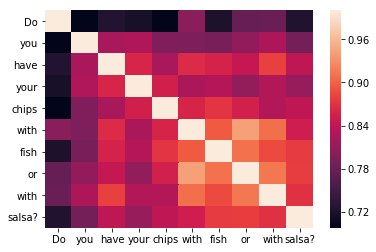

In [160]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

What do you see regarding the relations with chips and sala/fish? What about the other sentences? How about comparing sentence embeddings?

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that tune BERT to at least two different textual samples. These could be from different corpora, distinct time periods, separate authors, alternative publishing outlets, etc. Then compare the meaning of words, phrases and sentences to each other across the separate models. What do they reveal about the social worlds inscribed by the distinctive samples?

### Comparing Plato and Nietzsche

In [215]:
roberta_nietzsche_model_embedding = RobertaModel.from_pretrained('output_nietzsche_roberta')
roberta_nietzsche_tokenizer = RobertaTokenizer.from_pretrained('output_nietzsche_roberta')
roberta_plato_model_embedding = RobertaModel.from_pretrained('output_plato_roberta')
roberta_plato_tokenizer = RobertaTokenizer.from_pretrained('output_plato_roberta')

Some weights of RobertaModel were not initialized from the model checkpoint at output_nietzsche_roberta and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at output_plato_roberta and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


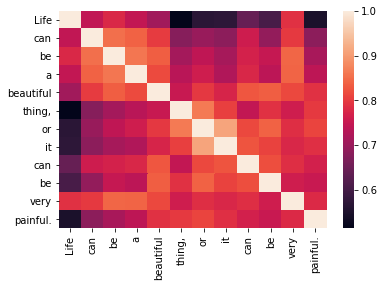

In [220]:
text = 'Life can be a beautiful thing, or it can be very painful.'
visualise_diffs(text, roberta_nietzsche_model_embedding, roberta_nietzsche_tokenizer)

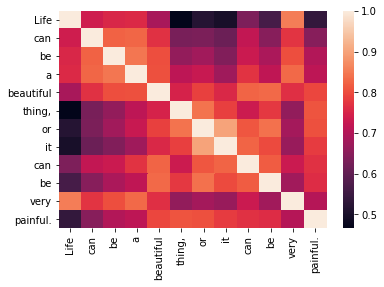

In [221]:
text = 'Life can be a beautiful thing, or it can be very painful.'
visualise_diffs(text, roberta_plato_model_embedding, roberta_plato_tokenizer)

When we input the sentence "Life can be a beautiful thing, or it can be very painful." into the Nietzsche and Plato RoBERTa models, minor differences arises. The pairs "be/very", "very/painful" are more similar in Nietzsche's work, than in Plato's work. The pair "life/very," however, appears more similar in Plato's text than in Nietzsche's.

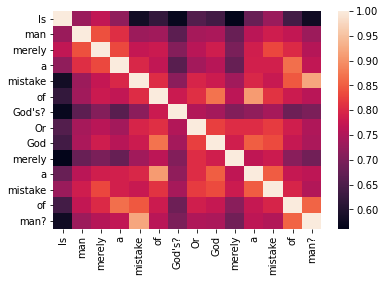

In [231]:
text = "Is man merely a mistake of God's? Or God merely a mistake of man?"
visualise_diffs(text, roberta_nietzsche_model_embedding, roberta_nietzsche_tokenizer)

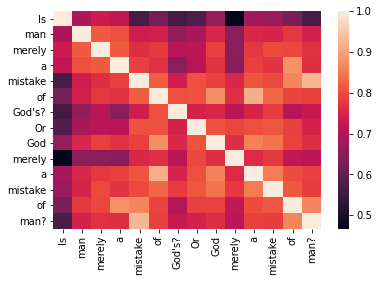

In [232]:
text = "Is man merely a mistake of God's? Or God merely a mistake of man?"
visualise_diffs(text, roberta_plato_model_embedding, roberta_plato_tokenizer)

We then input Nietzsche's quote "Is man merely a mistake of God's? Or God merely a mistake of man?" Interestingly, the pair of "God/man" is more similar in Plato's text than in Nietzsche's text, which makes sense since Nietzsche puts man more in opposition with God than Plato, and Plato lives in a polytheistic society (he will more often mention "gods").

Overall, we can see more differing colors in these two graphs. Although the differences are minuscule, they still show that the Nietzsche corpus differs from the Plato corpus in semantic space.